# TODO
**BE SURE TO ADD PATH TO `src/*` TO YOUR `ENVIROMENT/LIB/PYTHONVESRION/SITEPACKAGE/tnn.pth`** !
# Introduction to Tree NN

## Trees and DecisionUnits

In [45]:
from tnn import DecisionUnit, Tree
from models import Id
import torch
import torch.nn as nn

# simple model
class Double(nn.Module):
    def forward(self, x, training=None):
        return 2 * x

# tree either doubles x or leaves it
tree= Tree(1, [Id, Double()])

# For educational purpuses:
# We will set bias to 0 and weights to 0.5
# and get an uniform distribution over paths 
with torch.no_grad():
    tree.distribution.linear.weight.fill_(0.5)
    tree.distribution.linear.bias.fill_(0)

Lets sample a few outputs of this simple tree for input $[1]$ and calculate $E([1])$

In [46]:
x = torch.ones((1,))
print(f"input = {x}")
for i in range(5):
    print(tree(x, select_max=False).item(), end=";  " )
print()


E = tree.expected_value(lambda z : z,x)
print(f"E(Tree(x)) = {E}")

# batched input:
print("\nBATCHED INPUT:")
#batch = torch.tensor([[0], [1], [2], [3]], dtype=torch.float)
batch = torch.tensor([[1], [1], [1], [1]], dtype=torch.float)
print("input=\n", batch, "\n")

print("tree(batch):\n", tree(batch, select_max=False))

E = tree.expected_value(lambda z : z,batch)
print(f"E(Tree(batch)) = {E}")



input = tensor([1.])
1.0;  2.0;  2.0;  2.0;  2.0;  
E(Tree(x)) = tensor([1.5000], grad_fn=<ViewBackward0>)

BATCHED INPUT:
input=
 tensor([[1.],
        [1.],
        [1.],
        [1.]]) 

tree(batch):
 tensor([[2.],
        [1.],
        [2.],
        [1.]])
E(Tree(batch)) = tensor([[1.5000],
        [1.5000],
        [1.5000],
        [1.5000]], grad_fn=<SumBackward1>)


In [47]:
mse = torch.nn.MSELoss()

idisright = batch 
doubleisright = Double()(batch)

print(tree.expected_value(lambda u : (u - idisright ) ** 2  , batch).mean())
print(tree.expected_value(lambda u : (u - doubleisright ) ** 2  , batch).mean())
 
tree.E_mse(batch, idisright)

tensor(0.5000, grad_fn=<MeanBackward0>)
tensor(0.5000, grad_fn=<MeanBackward0>)


tensor(0.5000, grad_fn=<MeanBackward0>)

# Training
Different mothods of training will be shown. We will try to model a following function:
$$
f(x,y) = \begin{cases}
xy & x > 0, y > 0 \\
x + y & x > 0, y \leq  0 \\
2x \leq  0, y \leq  0 \\ 
y & x \leq 0, y > 0 \\
\end{cases}
$$

In [48]:
def f(x, y):
    if x > 0:
        if y > 0:
            return x * y 
        else:
            return x + y
    else:
        if y > 0:
            return y 
        else:
            return 2*x 

def vector_f(z):
    return f(z[0], z[1])

# get training data:
n_points = 100
n_data = n_points ** 2 
points = torch.linspace(-5, 5, n_points)
X = torch.zeros((n_data, 2))
Z = torch.zeros((n_data, 1))
for index_x in range(n_points):
    for index_y in range(n_points):
        x = points[index_x]
        y = points[index_y]
        X[index_y + index_x * n_points] = torch.tensor([x, y])
        Z[index_y + index_x * n_points] = f(x, y)

# get testing data:
n_points_training = 31
n_data_training = n_points_training ** 2 
points = torch.linspace(-5, 5, n_points_training)
test_X = torch.zeros((n_data_training, 2))
test_Z = torch.zeros((n_data_training, 1))
for index_x in range(n_points_training):
    for index_y in range(n_points_training):
        x = points[index_x]
        y = points[index_y]
        test_X[index_y + index_x * n_points_training] = torch.tensor([x, y])
        test_Z[index_y + index_x * n_points_training] = f(x, y)



In [49]:
for i in range(X.shape[0]):
    if not (Z[i] == vector_f(X[i])):
        raise ValueError
X.shape, Z.shape

(torch.Size([10000, 2]), torch.Size([10000, 1]))

## Shallow Tree model

In [50]:
from models import FeedForward
# get new tree
tree = Tree(2, [FeedForward(2, 3, 1), FeedForward(2, 3, 1)], head=FeedForward(2,2))

tree.n_params()

38

## Baseline 
We will compare the performance of different training settings to different simple Feedforward networks with the similar numbers of parameters

In [51]:
# tree has  6 + 6 + 13 + 13 = 38 parameters (6 for decision unit, 13 for Feedforward networks in leafs, 6 for feedforward in head)
n_params = tree.n_params()
baseline_models = [FeedForward(2,4,4 , 1), FeedForward(2,4,4,1), FeedForward(2, 10, 1)   ]

In [52]:
from torch.optim import Adam
from tqdm import tqdm
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau

optimisers = [Adam(model.parameters(), lr=0.01) for model in baseline_models]


opt = optimisers[0]
scheduler = ReduceLROnPlateau(opt, 'min', factor=0.7)
model = baseline_models[0]

n_epoch = 100
batch_size = 200
mse = torch.nn.MSELoss()


training_errors = []
validation_errors = [] 

for epoch in tqdm(range(n_epoch), total=n_epoch):
    for batch_index in range(n_data // batch_size):
        ############
        # get batch
        ############

        start = batch_size * batch_index
        stop = batch_size * (batch_index + 1)
        if batch_index == (n_data // batch_size) - 1:
            stop = n_data
        batchX = X[start:stop]
        batchZ = Z[start:stop]

        ############
        # train on batch
        ############

        # reset gradients
        opt.zero_grad()
        # get predictions and cost function
        outputs = model(batchX)
        loss = mse(outputs, batchZ)
        # calculate gradients
        loss.backward()
        # one step of optimisation
        opt.step()
    

    # collect results
    training_error = mse(model(X), Z)
    validation_error = mse(model(test_X), test_Z)
    training_errors.append(training_error)
    validation_errors.append(validation_error)


    # change learnign rate
    scheduler.step(validation_error)

    if epoch % 100 == 0:
        print(f"Epoch #{epoch +1}: Training error: {training_error}, validaion error: {validation_error}")

  3%|▎         | 3/100 [00:00<00:10,  9.19it/s]

Epoch #1: Training error: 25.141742706298828, validaion error: 26.392580032348633


100%|██████████| 100/100 [00:08<00:00, 11.56it/s]


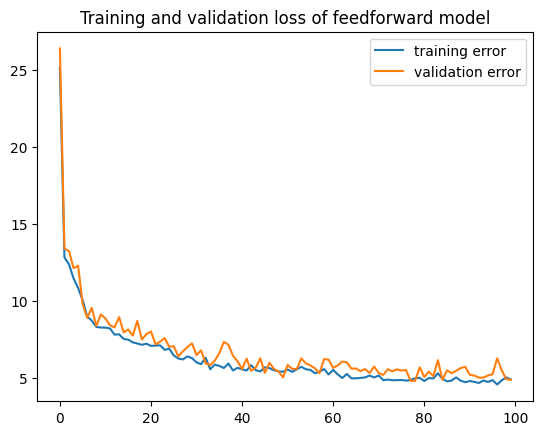

In [53]:
# plot errors
import matplotlib.pyplot as plt

#deatach all 
def deatach_list(lst):
    ans = []
    for x in lst:
        y = x.detach().numpy()
        ans.append(y)
    return ans


plt.plot(deatach_list(training_errors), label="training error")
plt.plot(deatach_list(validation_errors), label="validation error")
plt.legend()
plt.title("Training and validation loss of feedforward model")
plt.show()
# save for later
training_errors_feedforward = training_errors
validation_errors_feedforward = validation_errors


## Primitive training without additional cost function
We can just minimalize E[L(x)]. Bad performance expected.

In [54]:
# get new tree
tree = Tree(2, [FeedForward(2, 3, 1), FeedForward(2, 3, 1)], head=FeedForward(2,2))


In [55]:


# train the tree
from torch.optim import Adam
from tqdm import tqdm
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau

opt = Adam(tree.parameters(), lr=0.01)


scheduler = ReduceLROnPlateau(opt, "min", factor=0.7)
model = baseline_models[0]

n_epoch = 100
batch_size = 200
mse = torch.nn.MSELoss()


training_errors = []
validation_errors = []

for epoch in tqdm(range(n_epoch), total=n_epoch):
    for batch_index in range(n_data // batch_size):
        ############
        # get batch
        ############

        start = batch_size * batch_index
        stop = batch_size * (batch_index + 1)
        if batch_index == (n_data // batch_size) - 1:
            stop = n_data
        batchX = X[start:stop]
        batchZ = Z[start:stop]

        ############
        # train on batch
        ############

        # reset gradients
        opt.zero_grad()
        # get E(loss(branch(X))) - still of batch size

        expected_loss = tree.E_mse(batchX, batchZ)
        
        
        # get mean
        expected_loss = torch.mean(expected_loss, dim=0)
        

        # calculate gradients
        expected_loss.backward()


        # one step of optimisation
        opt.step()

    # collect results
    # training error:
    training_error = mse(tree(X), Z)
    validation_error = mse(tree(test_X), test_Z)

    training_errors.append(training_error)
    validation_errors.append(validation_error)

    # change learnign rate
    scheduler.step(validation_error)

    if epoch % 10 == 0:
        print(
            f"Epoch #{epoch +1}: Training error: {training_error}, validaion error: {validation_error}"
        )
        

  1%|          | 1/100 [00:00<00:25,  3.84it/s]

Epoch #1: Training error: 23.83563995361328, validaion error: 25.57822036743164


 11%|█         | 11/100 [00:03<00:33,  2.70it/s]

Epoch #11: Training error: 6.989557266235352, validaion error: 7.701620101928711


 21%|██        | 21/100 [00:07<00:29,  2.72it/s]

Epoch #21: Training error: 5.659061908721924, validaion error: 6.080226421356201


 31%|███       | 31/100 [00:10<00:25,  2.72it/s]

Epoch #31: Training error: 4.33560848236084, validaion error: 4.6836628913879395


 41%|████      | 41/100 [00:13<00:19,  3.05it/s]

Epoch #41: Training error: 3.8609957695007324, validaion error: 4.511529922485352


 51%|█████     | 51/100 [00:17<00:16,  2.90it/s]

Epoch #51: Training error: 3.734018325805664, validaion error: 4.860252380371094


 61%|██████    | 61/100 [00:20<00:11,  3.33it/s]

Epoch #61: Training error: 3.450355052947998, validaion error: 3.511467218399048


 71%|███████   | 71/100 [00:25<00:15,  1.85it/s]

Epoch #71: Training error: 3.430189847946167, validaion error: 3.6100995540618896


 81%|████████  | 81/100 [00:30<00:10,  1.74it/s]

Epoch #81: Training error: 3.3563787937164307, validaion error: 3.5385148525238037


 91%|█████████ | 91/100 [00:34<00:03,  2.88it/s]

Epoch #91: Training error: 3.1841444969177246, validaion error: 4.0829176902771


100%|██████████| 100/100 [00:37<00:00,  2.68it/s]


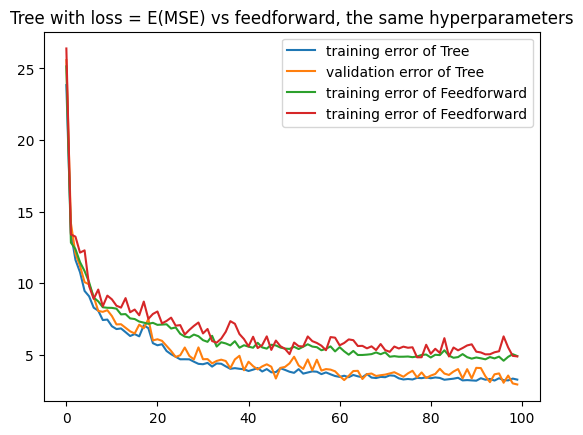

In [56]:
# plot errors
import matplotlib.pyplot as plt

#deatach all 
def deatach_list(lst):
    ans = []
    for x in lst:
        y = x.detach().numpy()
        ans.append(y)
    return ans


plt.plot(deatach_list(training_errors), label="training error of Tree")
plt.plot(deatach_list(validation_errors), label="validation error of Tree")
plt.plot(deatach_list(training_errors_feedforward), label="training error of Feedforward")
plt.plot(deatach_list(validation_errors_feedforward), label="training error of Feedforward")
plt.legend()
plt.title("Tree with loss = E(MSE) vs feedforward, the same hyperparameters")
plt.show()


# Primitive training + force softmax to converge to delta 
Mogoče se nam splača forsirat distribucijo (pred softmaxom..?) v to smer, da je na eni točki ful velika, drugje pa mala

In [57]:
# TODO

# 2-step training of Tree:
We can alternate between training the parameters of the inside linear layers and the parameters of the outside layers.

### Punish small gradients

In [58]:
# TODO


### Force inner network to be perpendicular to siblings of its parents

Slabo iz tega vidika, da mogoče na koncu  vseeno rabiš prevert kej, na kar smo bli pravkokotni

In [59]:
#TODO

### Štetje ničel v vektorju za vsakim hidden layerjem

In [60]:
#TODO

In [61]:
model = FeedForward(2, 2, 1)
list(model.parameters())

[Parameter containing:
 tensor([[-0.6311,  0.4256],
         [-0.1279, -0.2695]], requires_grad=True),
 Parameter containing:
 tensor([-0.1314, -0.2994], requires_grad=True),
 Parameter containing:
 tensor([[-0.6608, -0.2773]], requires_grad=True),
 Parameter containing:
 tensor([0.2314], requires_grad=True)]

In [62]:
-0.4032  -0.3246   -0.0350

-0.7628

In [63]:
x = torch.ones((2))
model(x, training=True)

[tensor([-0.3370, -0.6968], grad_fn=<ViewBackward0>),
 tensor([0., 0.], grad_fn=<ReluBackward0>),
 tensor([0., 0.], grad_fn=<MulBackward0>),
 tensor([0.2314], grad_fn=<ViewBackward0>)]

In [64]:

grads = torch.autograd.grad(
outputs=model(x),
inputs=[p for p in model.parameters() if p.requires_grad],
create_graph=True  # allows you to compute gradients of this gradient
)
grads

(tensor([[0., 0.],
         [0., 0.]], grad_fn=<TBackward0>),
 tensor([0., 0.], grad_fn=<ViewBackward0>),
 tensor([[0., 0.]], grad_fn=<TBackward0>),
 tensor([1.]))